In [434]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrices
# !pip install fancyimpute
from fancyimpute import IterativeImputer
import pickle
# !pip install geopandas
import geopandas as gpd
# Encoding
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Variance Inflation Factor (VIF) analysis to detect multi-collinearity
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

Read Data

In [399]:
data = pd.read_csv('data/exercise_40_train.csv')
# By using the .head() and .dtypes methods, we will get a general understanding of how the data looks like.
# There are 101 columns in total. Columns types include Object, int64, and float64
# It is difficult to interpret the data and generate features without meaningful column names.
# Descriptive statistic is a good way to look into to understand the distribution of the values in this situation.
print(data.dtypes.unique())
data.head()

[dtype('int64') dtype('float64') dtype('O')]


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.0062%,0.220784,1.816481,...,-0.397427,0.909479,no,5.492487,NaN,10.255579,7.627730,0,yes,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.0064%,1.192441,3.513950,...,0.656651,9.093466,no,3.346429,4.321172,NaN,10.505284,1,yes,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8e-04%,0.952323,0.782974,...,2.059615,0.305170,no,4.456565,NaN,8.754572,7.810979,0,yes,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.0057%,-0.520756,1.825586,...,0.899392,5.971782,no,4.100022,1.151085,NaN,9.178325,1,yes,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.0109%,-0.732739,2.151990,...,3.003595,1.046096,yes,3.234033,2.074927,9.987006,11.702664,0,yes,92.925935


In [400]:
# By using the describe method, we can identify that not all columns have the same number of variables. (x5, x11...)
# Null exist in some column and we will later on need to remove them through imputation
data.describe()

,y,x1,x2,x4,x5,x6,x8,x9,x10,x11,...,x89,x90,x91,x92,x94,x95,x96,x97,x98,x100
count,40000.000000,40000.000000,40000.000000,40000.000000,37572.000000,40000.000000,40000.000000,40000.000000,40000.000000,34890.000000,...,29309.000000,40000.000000,34741.000000,37565.000000,37660.000000,27396.000000,33362.000000,40000.000000,40000.000000,40000.000000
mean,0.145075,2.999958,20.004865,0.002950,0.005396,0.007234,0.004371,2.722334,0.490339,100.008988,...,10.767838,3.000166,0.001636,4.002896,3.969385,0.031886,10.525530,10.002814,0.497650,100.024743
std,0.352181,1.994490,1.604291,1.462185,1.297952,1.358551,1.447223,1.966828,1.029863,13.343010,...,3.732763,1.164411,1.468790,3.017420,1.473939,1.823091,1.437581,1.986984,0.500001,5.247514
min,0.000000,-3.648431,13.714945,-5.137161,-5.616412,-6.113153,-6.376810,-3.143438,-3.538129,50.526543,...,6.106024,-2.173310,-6.328126,-3.384399,-1.663063,-6.885150,8.210456,1.911272,0.000000,78.340735
25%,0.000000,1.592714,18.921388,-1.026798,-0.872354,-0.909831,-0.971167,1.340450,-0.207833,91.056682,...,7.927605,2.211125,-0.982679,1.610899,2.943758,-1.190682,9.397548,8.665103,0.000000,96.516856
50%,0.000000,2.875892,20.005944,0.002263,0.008822,0.007335,0.002226,2.498876,0.486926,100.020965,...,9.931831,2.998776,0.005664,4.099763,3.912526,0.001523,10.358355,9.994318,0.000000,100.024977
75%,0.000000,4.270295,21.083465,1.043354,0.892467,0.926222,0.985023,3.827712,1.182994,109.025025,...,12.710543,3.786751,0.989632,6.113157,4.930563,1.248742,11.448559,11.342574,1.000000,103.558762
max,1.000000,13.837591,27.086468,5.150153,5.698128,5.639372,5.869889,18.006669,4.724186,148.784484,...,38.566041,7.130058,6.868747,16.734658,11.669024,7.631773,18.725468,17.861580,1.000000,122.406809


In [401]:
# Separate Object, float, and integar variables

# Seperate response variable
y_df = data['y'].astype('int')
y_df.head()

# Object
category_df = data.loc[:,data.dtypes == np.object]
# Float
float_df = data.loc[:,data.dtypes == np.float64]
# Int
int_df = data.loc[:,data.dtypes == np.int64]
# The dependent variable y is also included in the int_df, we would want to exclude the column
int_df = int_df.drop(columns=['y'])

C:\Users\YunL\AppData\Local\Temp/ipykernel_6856/3941225013.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  category_df = data.loc[:,data.dtypes == np.object]


In [402]:
with open('y_df', 'wb') as y:
    pickle.dump(y_df, y, pickle.HIGHEST_PROTOCOL)

### Categorical Columns

By applying the .describe() method to categorical columns, we will be able to gauge some of the column meanings. For example:
- `x3` should be the week column, but it has 14 unique value, which later might require some data cleaning in order to be in the correct format.
- `x7` is a column related to the percentage (%) of something, we can transfer it back to numerical column for better interpretation.
- `x19` is a column related to positive and negative value ($), we should transform it back to numerical column as well.
- `x24` might be the gender column
- `x31` and `x93` are columns providing yes or no answer, while `x99` only provides yes or null value.
- `x33` is the state column.
- `x39` is a column indicating miles, interestingly, the only unique answer is 5-10 miles, which it might not provide much meaning in our analysis.
- `x60` is the month column with exact 12 unique values.
- `x65` and `x77` are the highlight in this categorical data. `x65` It is a column related to which insurance company the record belongs to, includes `farmers`, `allstate`, `geico`, `progressive`, and `esurance`, and `x77` shows the brand of the car for the record, includes `mercedes`, `subaru`, `nissan`, `toyota`, `chevrolet` and null value.

In [403]:
category_df.describe()

,x3,x7,x19,x24,x31,x33,x39,x60,x65,x77,x93,x99
count,40000,40000,40000,36144,40000,32829,40000,40000,40000,30743,40000,27164
unique,14,663,40000,2,2,51,1,12,5,7,2,1
top,Wednesday,0.0022%,$-908.650758424405,female,no,California,5-10 miles,December,progressive,ford,no,yes
freq,4930,193,1,18158,34022,3393,40000,8136,10877,9005,35506,27164


In [404]:
# See what unique values within `x3`
print(category_df['x3'].unique())

def weekday_mapping(row):
    if row == 'Monday' or row == 'Mon':
        return 'Mon'
    elif row == 'Tuesday' or row == 'Tue':
        return 'Tue'
    elif row == 'Wednesday' or row == 'Wed':
        return 'Wed'
    elif row == 'Thursday' or row == 'Thur':
        return 'Thur'
    elif row == 'Friday' or row == 'Fri':
        return 'Fri'
    elif row == 'Saturday' or row == 'Sat':
        return 'Sat'
    elif row == 'Sunday' or row == 'Sun':
        return 'Sun'
        
category_df['x3'] = category_df['x3'].apply(weekday_mapping)
category_df = category_df.rename(columns={'x3': 'weekday'})
print(category_df['weekday'].unique())

['Wed' 'Friday' 'Thursday' 'Tuesday' 'Sunday' 'Saturday' 'Sat' 'Wednesday'
 'Sun' 'Tue' 'Thur' 'Monday' 'Fri' 'Mon']
['Wed' 'Fri' 'Thur' 'Tue' 'Sun' 'Sat' 'Mon']


C:\Users\YunL\AppData\Local\Temp/ipykernel_6856/8236519.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['x3'] = category_df['x3'].apply(weekday_mapping)


In [405]:
# Rename x24 to gender, x33 to state, x60 to month, x65 to insurance_company, x77 to car_brand
# Since x7 is related to percentage and x19 is related to money, I decided to make a note of that in the column name as well
category_df = category_df.rename(columns={'x24': 'gender',
                                          'x33': 'state',
                                          'x60': 'month',
                                          'x65': 'insurance_company',
                                          'x77': 'car_brand',
                                          'x7': 'x7_percentage',
                                          'x19': 'x19_money'})
category_df.head()

,weekday,x7_percentage,x19_money,gender,x31,state,x39,month,insurance_company,car_brand,x93,x99
0,Wed,0.0062%,$-908.650758424405,female,no,Colorado,5-10 miles,August,farmers,mercedes,no,yes
1,Fri,0.0064%,$-1864.9622875143,male,no,Tennessee,5-10 miles,April,allstate,mercedes,no,yes
2,Thur,-8e-04%,$-543.187402955527,male,no,Texas,5-10 miles,September,geico,subaru,no,yes
3,Tue,-0.0057%,$-182.626380634258,male,no,Minnesota,5-10 miles,September,geico,nissan,no,yes
4,Sun,0.0109%,$967.007090837503,male,yes,New York,5-10 miles,January,geico,toyota,yes,yes


In [406]:
# Convert categorical variables `x7 (%)` and `x9 ($)` to numeric
category_df['x7_percentage'] = category_df['x7_percentage'].str.replace('%', '').astype(float)
category_df['x19_money'] = category_df['x19_money'].str.replace('$','').astype(float)

# Delete `x39` since it has only one unique value within the entire column
category_df = category_df.drop(columns=['x39'])

C:\Users\YunL\AppData\Local\Temp/ipykernel_6856/981040905.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  category_df['x19_money'] = category_df['x19_money'].str.replace('$','').astype(float)


In [407]:
# Combine the original categorical column, now float columns (x7, x19) to the float_df
float_df = pd.concat([float_df, category_df[['x7_percentage','x19_money']]], axis=1)
float_df.head()

# Delete the x7 and x19 columns from category_df
category_df = category_df.drop(columns=['x7_percentage','x19_money'])
category_df.head()

,weekday,gender,x31,state,month,insurance_company,car_brand,x93,x99
0,Wed,female,no,Colorado,August,farmers,mercedes,no,yes
1,Fri,male,no,Tennessee,April,allstate,mercedes,no,yes
2,Thur,male,no,Texas,September,geico,subaru,no,yes
3,Tue,male,no,Minnesota,September,geico,nissan,no,yes
4,Sun,male,yes,New York,January,geico,toyota,yes,yes


#### Exploration/ Viz

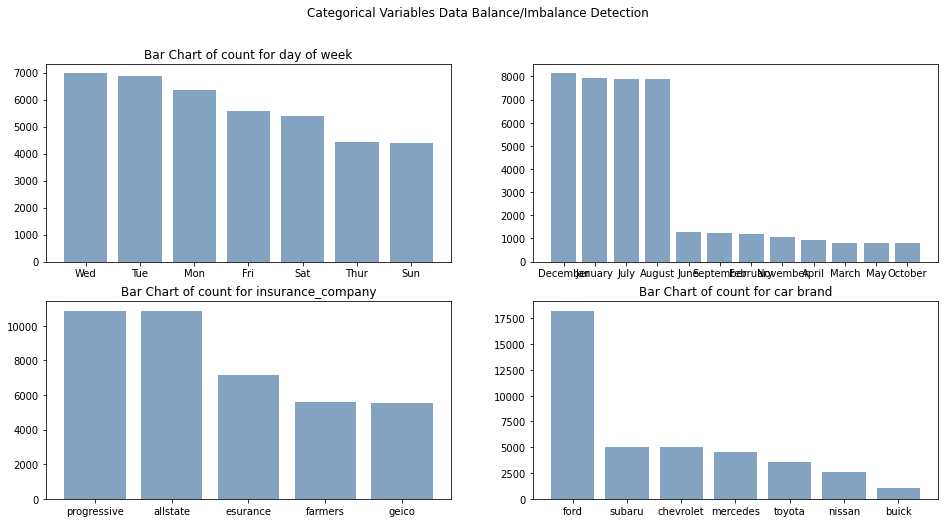

In [581]:

# Create a 2x2 grid of subplots to visualize whether if data imbalance exists
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Plot the data on each subplot
weekday_count = category_df['weekday'].value_counts().reset_index().rename(columns={'index':'dayOfWeek','weekday':'count'})
g1 = axs[0, 0].bar(weekday_count['dayOfWeek'], weekday_count['count'], color=(0.2, 0.4, 0.6, 0.6))
axs[0, 0].set_title('Bar Chart of count for day of week')

month_count = category_df['month'].value_counts().reset_index().rename(columns={'month':'count','index':'month'})
g2 = axs[0, 1].bar(month_count['month'], month_count['count'], color=(0.2, 0.4, 0.6, 0.6))
axs[0, 0].set_title('Bar Chart of count for day of week')

insurance_com_count = category_df['insurance_company'].value_counts().reset_index().rename(columns={'insurance_company':'count','index':'insurance_company'})
g3 = axs[1, 0].bar(insurance_com_count['insurance_company'], insurance_com_count['count'], color=(0.2, 0.4, 0.6, 0.6))
axs[1, 0].set_title('Bar Chart of count for insurance_company')

car_brand_count = category_df['car_brand'].value_counts().reset_index().rename(columns={'car_brand':'count','index':'car_brand'})
g4 = axs[1, 1].bar(car_brand_count['car_brand'], car_brand_count['count'], color=(0.2, 0.4, 0.6, 0.6))
axs[1, 1].set_title('Bar Chart of count for car brand')

# Add a main title
fig.suptitle('Categorical Variables Data Balance/Imbalance Detection')

# Show the plot
plt.show()


In [524]:
category_df_y = pd.concat([category_df,y_df], axis=1)

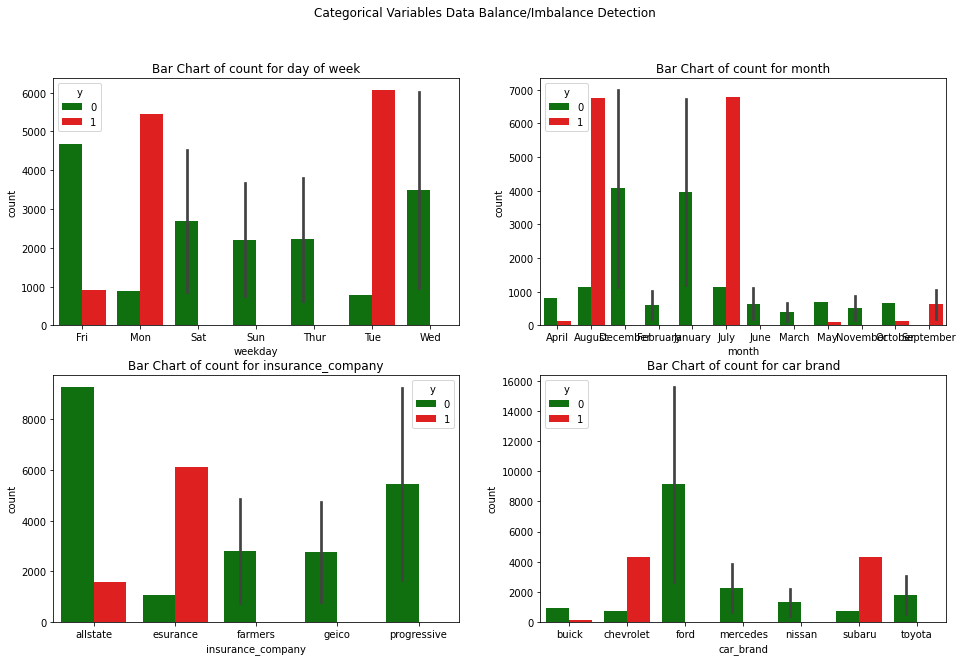

In [525]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
colors = ['green', 'red']

# Plot the instance for target value = 1 and 0 on each subplot groupby the cateforical variable
weekday_count = category_df_y.groupby('weekday')['y'].value_counts().to_frame().rename(columns={'y':'count'}).reset_index()
g1 = sns.barplot(x='weekday', y='count', data=weekday_count, hue=data['y'], palette=colors, ax=axs[0, 0])
g1.set_title('Bar Chart of count for day of week')

month_count = category_df_y.groupby('month')['y'].value_counts().to_frame().rename(columns={'y':'count'}).reset_index()
g2 = sns.barplot(x='month', y='count', data=month_count, hue=data['y'], palette=colors, ax=axs[0, 1])
g2.set_title('Bar Chart of count for month')

insurance_com_count = category_df_y.groupby('insurance_company')['y'].value_counts().to_frame().rename(columns={'y':'count'}).reset_index()
g3 = sns.barplot(x='insurance_company', y='count', data=insurance_com_count, hue=data['y'], palette=colors, ax=axs[1, 0])
g3.set_title('Bar Chart of count for insurance_company')

car_brand_count = category_df_y.groupby('car_brand')['y'].value_counts().to_frame().rename(columns={'y':'count'}).reset_index()
g4 = sns.barplot(x='car_brand', y='count', data=car_brand_count, hue=data['y'], palette=colors, ax=axs[1, 1])
g4.set_title('Bar Chart of count for car brand')

# Add a main title
fig.suptitle('Categorical Variables Data Balance/Imbalance Detection')

# Show the plot
plt.show()

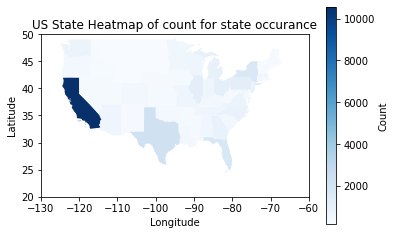

In [584]:
# Load US states shapefile
states = gpd.read_file('geopd/cb_2018_us_state_500k.shp')

def plot_geo(states):
    fig, ax = plt.subplots()
    states.plot(column='count',
                cmap='Blues',
                ax=ax,
                legend=True,
                legend_kwds={'label': 'Count'})
    ax.set_xlim(-130, -60)
    ax.set_ylim(20, 50)
    ax.set_title('US State Heatmap of count for state occurance')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

state_count = category_df['state'].value_counts().to_dict()
states = states.merge(pd.DataFrame({'NAME': list(state_count.keys()),
                                    'count': list(state_count.values())}),
                      on='NAME')    
plot_geo(states)

In [578]:
state_y_mean = category_df_y.groupby('state')['y'].mean()

# Convert the result to a dataframe and rename the column
state_y_percentage = pd.DataFrame(state_y_mean*100).rename(columns={'y': 'y_1_percentage'}).sort_values(by='y_1_percentage', ascending=False).reset_index()

# Testing to make sure the calculation is correct
# a = category_df_y.groupby('state')['y'].value_counts().to_frame().rename(columns={'y':'count'}).reset_index()
# a[a['state'] == 'Alaska'] # returns 0.3125

In [586]:
state_y_percentage

{'Alaska': 31.25,
 'Idaho': 30.324909747292416,
 'Oregon': 27.654867256637168,
 'Washington': 26.0,
 'Montana': 23.076923076923077,
 'Kansas': 21.957671957671955,
 'North Carolina': 21.0989010989011,
 'Illinois': 19.032258064516128,
 'Georgia': 18.845315904139433,
 'Iowa': 18.69688385269122,
 'Vermont': 18.461538461538463,
 'Florida': 18.312985571587127,
 'Missouri': 17.665615141955836,
 'Ohio': 17.594254937163374,
 'South Carolina': 17.311608961303463,
 'Indiana': 16.61721068249258,
 'Kentucky': 16.527196652719663,
 'Nebraska': 15.479876160990713,
 'South Dakota': 15.300546448087433,
 'Maine': 14.979757085020243,
 'New Hampshire': 14.71861471861472,
 'Hawaii': 14.184397163120568,
 'Rhode Island': 13.821138211382115,
 'Connecticut': 13.507109004739338,
 'DC': 13.440860215053762,
 'Nevada': 13.404825737265416,
 'New York': 13.36056009334889,
 'Mississippi': 13.29639889196676,
 'California': 13.214691404770921,
 'Massachusetts': 13.009404388714735,
 'Texas': 12.699822380106571,
 'Wiscons

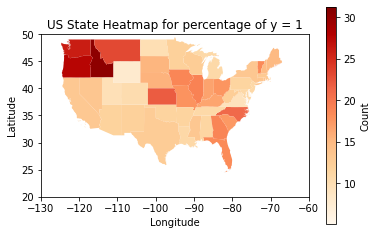

In [580]:
# Load US states shapefile
states = gpd.read_file('geopd/cb_2018_us_state_500k.shp')

def plot_geo(states):
    fig, ax = plt.subplots()
    states.plot(column='count',
                cmap='OrRd',
                ax=ax,
                legend=True,
                legend_kwds={'label': 'Count'})
    ax.set_xlim(-130, -60)
    ax.set_ylim(20, 50)
    ax.set_title('US State Heatmap for percentage of y = 1')
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

# state_count = category_df['state'].value_counts().to_dict()
# states = states.merge(pd.DataFrame({'NAME': list(state_y_percentage.keys()),
#                                     'count': list(state_y_percentage.values())}),
#                       on='NAME')    
state_y_percentage = state_y_percentage.set_index('state')['y_1_percentage'].to_dict()
states = states.merge(pd.DataFrame({'NAME': list(state_y_percentage.keys()),
                                    'count': list(state_y_percentage.values())}),
                      on='NAME')    
plot_geo(states)

California, Texas, Florida, and New York are the states that have the highest occurance among all 51 states. However, we do not know the relationship between state and the target value yet.

<AxesSubplot:>

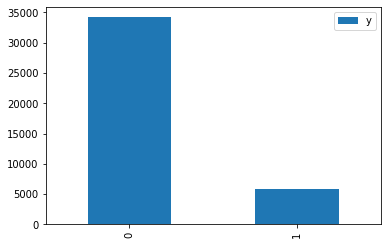

In [447]:
data['y'].value_counts().plot.bar(y='count', legend='target variable')

<AxesSubplot:>

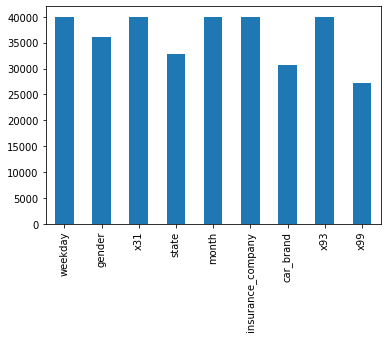

In [424]:
# We can visualize the columns with obvious null values (gender, state, car_brand, x99)
category_df.describe().transpose().plot.bar(y='count', legend=None)

#### Imputation

In [425]:
# Impute categorical missing values using most frequent
def impute_most_frequent(col):
    return col.value_counts().index[0]
category_df = category_df.apply(lambda col: col.fillna(impute_most_frequent(col)))

# Make sure all null values are imputed
category_df.isnull().sum()

weekday              0
gender               0
x31                  0
state                0
month                0
insurance_company    0
car_brand            0
x93                  0
x99                  0
dtype: int64

#### Encode Categorical columns

Perform both Label Encoding and One Hot Encoding. Label Encoder will assign a unique integar value to each category in the variables. While One Hot Encoding creates a new binary feature for each category in the variable.

In [426]:
le = LabelEncoder()
cat_df = category_df.apply(le.fit_transform)
cat_df.head()

,weekday,gender,x31,state,month,insurance_company,car_brand,x93,x99
0,6,0,0,5,1,2,3,0,0
1,0,1,0,42,0,0,3,0,0
2,4,1,0,43,11,3,5,0,0
3,5,1,0,23,11,3,4,0,0
4,3,1,1,32,4,3,6,1,0


In [427]:
onehot_prefix_pipeline = Pipeline([
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore')),
])

ct = ColumnTransformer(
    transformers=[('onehot_prefix', onehot_prefix_pipeline, cat_df.columns)],
    remainder='passthrough'
)

data_encoded = pd.DataFrame(ct.fit_transform(cat_df))
column_names = ct.named_transformers_['onehot_prefix'].named_steps['onehot'].get_feature_names(cat_df.columns)
data_encoded.columns = column_names.tolist() + cat_df.columns[len(column_names):].tolist()

data_encoded.head()

c:\Users\YunL\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,gender_0,gender_1,x31_0,...,car_brand_0,car_brand_1,car_brand_2,car_brand_3,car_brand_4,car_brand_5,car_brand_6,x93_0,x93_1,x99_0
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [428]:
with open('onehot_prefix_pipeline', 'wb') as e:
    pickle.dump(onehot_prefix_pipeline, e, pickle.HIGHEST_PROTOCOL)

### Numerical Columns

In [429]:
# Combine float_df and int_df
num_df = pd.concat([float_df, int_df], axis=1)
# Imputation
imp = IterativeImputer()
imp_num_df = pd.DataFrame(imp.fit_transform(num_df))
imp_num_df.index = num_df.index
imp_num_df.columns = num_df.columns


In [430]:
# Save the imputation using pickle for later model replication
with open('imp', 'wb') as i:
    pickle.dump(imp, i, pickle.HIGHEST_PROTOCOL)

### Combine categorical and numerical dataframe

In [431]:
x_df = pd.concat([data_encoded, imp_num_df], axis=1)
x_df.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,gender_0,gender_1,x31_0,...,x92,x94,x95,x96,x97,x100,x7_percentage,x19_money,x59,x98
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.909479,5.492487,-1.078435,10.255579,7.627730,104.251338,0.0062,-908.650758,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,9.093466,3.346429,4.321172,7.874850,10.505284,101.230645,0.0064,-1864.962288,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.305170,4.456565,-0.520096,8.754572,7.810979,109.345215,-0.0008,-543.187403,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,5.971782,4.100022,1.151085,8.265926,9.178325,103.021970,-0.0057,-182.626381,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.046096,3.234033,2.074927,9.987006,11.702664,92.925935,0.0109,967.007091,0.0,0.0


In [432]:
with open('x_df', 'wb') as x:
    pickle.dump(x_df, x, pickle.HIGHEST_PROTOCOL)